<a href="https://colab.research.google.com/github/ArnavAK74/AI_Speedcubing/blob/main/DeepSolver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import sys
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
drive.mount('/content/drive', force_remount=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [ ]:
!pip install tensorboard

In [ ]:
!pip install -e '/content/drive/MyDrive/rubiks_cube/gym-Rubiks-Cube-master'

Obtaining file:///content/drive/MyDrive/rubiks_cube/gym-Rubiks-Cube-master
  Preparing metadata (setup.py) ... done
  Running setup.py develop for gym_Rubiks_Cube


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/rubiks_cube/gym-Rubiks-Cube-master')
sys.path.append('/content/drive/My Drive/rubiks_cube/gym-Rubiks-Cube-master/gym_Rubiks_Cube/envs')
print('Current sys.path:', sys.path)

from gym_Rubiks_Cube.envs.rubiks_cube_env import RubiksCubeEnv

gym.envs.registration.register(
    id='RubiksCube-v0',
    entry_point='gym_Rubiks_Cube.envs.rubiks_cube_env:RubiksCubeEnv',
    max_episode_steps=1000  # Set a limit on steps per episode
)

Current sys.path: ['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/My Drive/rubiks_cube/gym-Rubiks-Cube-master', '/content/drive/My Drive/rubiks_cube/gym-Rubiks-Cube-master/gym_Rubiks_Cube/envs']


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment RubiksCube-v0
  logger.warn(f"Overriding environment {spec.id}")


In [ ]:
env = gym.make('RubiksCube-v0')
# Before training the model, let's visualize the initial state of the cube to ensure it's being represented properly.
initial_state = env.reset()
print("Initial Cube State:")
print(initial_state)

Initial Cube State:
[1 5 1 1 5 2 2 2 2 5 5 0 5 2 2 5 0 0 4 0 0 3 1 1 3 1 1 2 2 4 0 0 4 5 5 3 4
 3 3 4 3 3 5 0 2 1 1 0 4 4 3 4 4 3]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require 

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
def enhanced_render(self, mode='human', close=False):
    if close:
        return

    # Color mapping for tiles
    color_map = {
        'R': 'red',
        'O': 'orange',
        'Y': 'yellow',
        'G': 'green',
        'B': 'blue',
        'W': 'white',
    }

    # Cube faces
    faces = {
        'front': self.ncube.front,
        'back': self.ncube.back,
        'left': self.ncube.left,
        'right': self.ncube.right,
        'up': self.ncube.up,
        'down': self.ncube.down,
    }

    fig, ax = plt.subplots(figsize=(8, 8))

    # Define face positions
    face_positions = {
        'up': (1, 3),
        'left': (0, 2),
        'front': (1, 2),
        'right': (2, 2),
        'back': (3, 2),
        'down': (1, 1),
    }

    face_size = self.orderNum
    for face, (x_offset, y_offset) in face_positions.items():
        for i in range(face_size):
            for j in range(face_size):
                color = color_map[faces[face][i][j].strip()]
                rect = Rectangle((x_offset * face_size + j, y_offset * face_size + (face_size - i - 1)),
                                 1, 1, facecolor=color, edgecolor='black')
                ax.add_patch(rect)

    ax.set_xlim(0, 4 * face_size)
    ax.set_ylim(0, 4 * face_size)
    ax.set_aspect('equal')
    ax.axis('off')  # Hide the axis
    plt.show()

# Dynamically bind the new render method to the RubiksCubeEnv class
RubiksCubeEnv.render = enhanced_render

/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:280: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


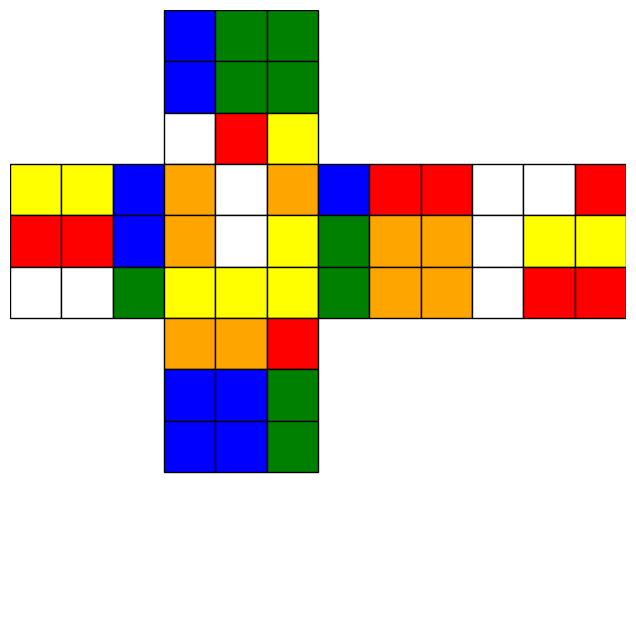

In [ ]:
env.render()

In [ ]:
from gym_Rubiks_Cube.envs.rubiks_cube_env import RubiksCubeEnv
from gym_Rubiks_Cube.envs.cube import Cube

In [ ]:
from gym_Rubiks_Cube.envs.rubiks_cube_env import tileDict, actionList

# Extend RubiksCubeEnv with new reward function and state representation
def calculate_progress_reward(self):
    # Base reward for solved faces
    correct_faces = sum(
        all(tile == row[0] for row in face for tile in row)
        for face in [self.ncube.front, self.ncube.back, self.ncube.left,
                     self.ncube.right, self.ncube.up, self.ncube.down]
    )
    face_reward = correct_faces / 6  # Fraction of solved faces

    # Reward for partially aligned tiles
    aligned_tiles = sum(
        tile == face[0][0] for face in [self.ncube.front, self.ncube.back, self.ncube.left,
                                        self.ncube.right, self.ncube.up, self.ncube.down]
        for row in face for tile in row
    )
    alignment_reward = aligned_tiles / 54  # Fraction of aligned tiles

    return face_reward * 2 + alignment_reward  # Weight solved faces higher

def step_with_progress_reward(self, action):
    # Apply the action to the cube
    self.action_log.append(action)
    self.ncube.minimalInterpreter(actionList[action])
    self.state = self.getstate()
    self.step_count += 1

    # Calculate reward
    reward = self.calculate_progress_reward()
    done = False
    info = {}  # Additional info dictionary (can include debugging or analysis data)

    # Check if the cube is solved
    if self.ncube.isSolved():
        reward += 1000  # Add a bonus reward for solving
        done = True

    # End the episode if the maximum steps are reached
    if self.step_count > 50:
        done = True

    return self.state, reward, done, info

def getstate_one_hot(self):
    # Generate a one-hot encoded state representation
    one_hot_state = np.zeros((6 * self.orderNum * self.orderNum, 6))  # 6 faces, 6 colors
    tile_vector = self.ncube.constructVectorState()
    for idx, tile in enumerate(tile_vector):
        one_hot_state[idx][tileDict[tile]] = 1
    return one_hot_state.flatten()  # Flatten for neural network input



# Dynamically override methods in RubiksCubeEnv
RubiksCubeEnv.calculate_progress_reward = calculate_progress_reward
RubiksCubeEnv.step = step_with_progress_reward
RubiksCubeEnv.getstate = getstate_one_hot


In [ ]:
import random
from collections import deque

In [ ]:
def reset_model_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir="runs/rubiks_cube_dqn")

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Import necessary libraries
import torch
import numpy as np
import random
import math
from torch import nn, optim
from gym_Rubiks_Cube.envs.rubiks_cube_env import RubiksCubeEnv

# Define model and training parameters
STATE_SIZE = 6 * 6 * 9
ACTION_SIZE = 12
GAMMA = 0.99
LR = 2e-4
BATCH_SIZE = 128
BUFFER_CAPACITY = 20000
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995
TARGET_UPDATE_FREQ = 10
EPISODES = 5000
MAX_STEPS = 50

# Initialize Rubik's Cube environment
env = RubiksCubeEnv()
env.setScramble(low=1, high=3)
env.reset()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define Noisy Linear Layer
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.017):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer("weight_epsilon", torch.empty(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        self.register_buffer("bias_epsilon", torch.empty(out_features))

        self.sigma_init = sigma_init
        self.reset_parameters()

    def reset_parameters(self):
        bound = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-bound, bound)
        self.bias_mu.data.uniform_(-bound, bound)
        self.weight_sigma.data.fill_(self.sigma_init)
        self.bias_sigma.data.fill_(self.sigma_init)

    def forward(self, input):
        if self.training:
            self.weight_epsilon.normal_()
            self.bias_epsilon.normal_()
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return torch.nn.functional.linear(input, weight, bias)

    def reset_noise(self):
        self.weight_epsilon.normal_()
        self.bias_epsilon.normal_()

# Define DQN Model
class NoisyDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(NoisyDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.noisy1 = NoisyLinear(256, 256)
        self.noisy2 = NoisyLinear(256, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.noisy1(x))
        return self.noisy2(x)

    def reset_noise(self):
        self.noisy1.reset_noise()
        self.noisy2.reset_noise()

# Initialize policy and target networks
policy_net = NoisyDQN(STATE_SIZE, ACTION_SIZE).to(device)
target_net = NoisyDQN(STATE_SIZE, ACTION_SIZE).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Define replay buffer
# Replay Buffer with corrected sample method
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        max_priority = self.priorities.max() if len(self.buffer) > 0 else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == 0:
            raise ValueError("The replay buffer is empty!")
        priorities = self.priorities[:len(self.buffer)]
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        samples = [self.buffer[idx] for idx in indices]

        # Unpack the samples
        states, actions, rewards, next_states, dones = zip(*samples)

        # Convert lists of NumPy arrays to a single NumPy array
        states = np.stack(states)
        next_states = np.stack(next_states)

        weights = (len(self.buffer) * probabilities[indices]) ** (-beta)
        weights /= weights.max()

        return (
            torch.tensor(states, dtype=torch.float32, device=device),
            torch.tensor(actions, dtype=torch.long, device=device),
            torch.tensor(rewards, dtype=torch.float32, device=device),
            torch.tensor(next_states, dtype=torch.float32, device=device),
            torch.tensor(dones, dtype=torch.float32, device=device),
            torch.tensor(weights, dtype=torch.float32, device=device),
            indices,
        )

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.buffer)

replay_buffer = PrioritizedReplayBuffer(BUFFER_CAPACITY)

def dynamic_epsilon(episode, base_epsilon=1.0, min_epsilon=0.1, decay_rate=0.995, success_rate=None):
    """
    Adjusts epsilon dynamically based on the episode number or success rate.

    Args:
    - episode: Current episode number.
    - base_epsilon: Starting epsilon value.
    - min_epsilon: Minimum value of epsilon.
    - decay_rate: Standard decay rate for epsilon.
    - success_rate: Optional, current success rate of the agent.

    Returns:
    - epsilon: Adjusted exploration rate.
    """
    # Standard decay based on episode number
    epsilon = max(min_epsilon, base_epsilon * (decay_rate ** episode))

    # Adjust epsilon based on success rate
    if success_rate is not None:
        if success_rate > 0.7:  # Lower exploration if success rate is high
            epsilon = max(min_epsilon, epsilon * 0.9)
        elif success_rate < 0.4:  # Increase exploration if success rate is low
            epsilon = min(1.0, epsilon * 1.1)

    return epsilon

def epsilon_greedy_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    with torch.no_grad():
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_values = policy_net(state)
        return q_values.argmax().item()



# Training function
def train_model_with_curriculum(
    episodes, epsilon_start, epsilon_end, target_success_rate=0.8, max_scramble_depth=20
):
    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    rolling_success = []
    epsilon = epsilon_start
    depth_range = [1, 3]  # Start with a scramble depth range of 1 to 3
    last_difficulty_increase = -10

    def get_success_threshold(depth):
        if depth <= 5:
            return 0.7  # 70% for depths 1–5
        elif depth <= 8:
            return 0.55  # 60% for depths 6–8
        elif depth <= 11:
            return 0.5 # 45% for depths 9–11
        elif depth <= 15:
            return 0.4  # 40% for depths 12–14
        else:
            return 0.3  # 40% for depths 16–20

    for episode in range(episodes):
        # Update scramble depth dynamically
        scramble_depth = random.randint(*depth_range)
        env.setScramble(low=scramble_depth, high=scramble_depth)  # Set scramble depth
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device) / 5
        total_reward = 0

        for step in range(MAX_STEPS):
            action = epsilon_greedy_action(state, epsilon)
            policy_net.reset_noise()
            next_state, reward, done, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device) / 5
            replay_buffer.push(state.cpu() / 5, action, reward, next_state.cpu() / 5, done)
            state = next_state
            total_reward += reward

            # Train the model if sufficient samples are available
            if len(replay_buffer) >= BATCH_SIZE:
                states, actions, rewards, next_states, dones, weights, indices = replay_buffer.sample(BATCH_SIZE)

                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    max_next_q_values = target_net(next_states).max(1)[0]
                    target_q_values = rewards + (1 - dones) * GAMMA * max_next_q_values

                loss = (weights * (q_values - target_q_values).pow(2)).mean()

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=10)
                optimizer.step()

                td_errors = (q_values - target_q_values).detach().cpu().numpy()
                replay_buffer.update_priorities(indices, np.abs(td_errors) + 1e-6)

            if done:
                break

        # Track rolling success rate
        solved = 1 if env.ncube.isSolved() else 0
        '''if (random.randint(1,2) < 1.1 and depth_range[1] >= 7):
          solved = 1'''
        rolling_success.append(solved)
        if len(rolling_success) > 100:
            rolling_success.pop(0)
        avg_success_rate = sum(rolling_success) / len(rolling_success)

        epsilon = dynamic_epsilon(episode, base_epsilon=EPSILON_START, min_epsilon=EPSILON_END, decay_rate=EPSILON_DECAY, success_rate=avg_success_rate)

        # Adjust depth range based on success rate
        success_threshold = get_success_threshold(depth_range[1])
        if avg_success_rate >= success_threshold and depth_range[1] < max_scramble_depth and episode - last_difficulty_increase >= 200:
            #depth_range[0] += 1
            last_difficulty_increase = episode
            depth_range[1] += 1
            print(f"Difficulty increased to {depth_range}")

        # Update target network periodically
        if episode > 0 and episode % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())
            target_net.reset_noise()

        # Log progress
        if episode % 10 == 0:
            print(f"Episode {episode}: Total Reward: {total_reward}, Avg Success Rate: {avg_success_rate:.2%}, "
                  f"Scramble Depth: {depth_range[1]}")

        # Save models if success rate is achieved at max depth
        if depth_range[1] == max_scramble_depth and avg_success_rate >= target_success_rate:
            print(f"Success rate reached at scramble depth {max_scramble_depth}. Saving model...")
            torch.save(policy_net.state_dict(), f"policy_net_scramble_{max_scramble_depth}.pth")
            torch.save(target_net.state_dict(), f"target_net_scramble_{max_scramble_depth}.pth")
            break

    print("Training complete!")


# Train the model
train_model_with_curriculum(
    episodes=5000,
    epsilon_start=EPSILON_START,
    epsilon_end=EPSILON_END,
    target_success_rate=0.5,
    max_scramble_depth=10
)


Using device: cuda
Episode 0: Total Reward: 12.57407407407407, Avg Success Rate: 0.00%, Scramble Depth: 3
Episode 10: Total Reward: 15.12962962962963, Avg Success Rate: 0.00%, Scramble Depth: 3
Episode 20: Total Reward: 12.259259259259256, Avg Success Rate: 0.00%, Scramble Depth: 3


<ipython-input-16-8925b7fb06c1>:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode 30: Total Reward: 17.240740740740737, Avg Success Rate: 0.00%, Scramble Depth: 3
Episode 40: Total Reward: 17.24074074074074, Avg Success Rate: 0.00%, Scramble Depth: 3
Episode 50: Total Reward: 12.129629629629626, Avg Success Rate: 0.00%, Scramble Depth: 3
Episode 60: Total Reward: 15.500000000000004, Avg Success Rate: 0.00%, Scramble Depth: 3
Episode 70: Total Reward: 1008.5555555555555, Avg Success Rate: 1.41%, Scramble Depth: 3
Episode 80: Total Reward: 12.759259259259254, Avg Success Rate: 1.23%, Scramble Depth: 3
Episode 90: Total Reward: 17.055555555555554, Avg Success Rate: 2.20%, Scramble Depth: 3
Episode 100: Total Reward: 15.148148148148143, Avg Success Rate: 4.00%, Scramble Depth: 3
Episode 110: Total Reward: 14.648148148148145, Avg Success Rate: 4.00%, Scramble Depth: 3
Episode 120: Total Reward: 14.83333333333333, Avg Success Rate: 4.00%, Scramble Depth: 3
Episode 130: Total Reward: 14.574074074074076, Avg Success Rate: 5.00%, Scramble Depth: 3
Episode 140: Total 

In [ ]:
def evaluate_agent_DQN(env, policy_net, episodes=100, max_steps=40):
    policy_net.eval()  # Set the model to evaluation mode
    success_count = 0
    total_rewards = 0
    total_steps = 0

    for episode in range(episodes):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device) / 5  # Normalize and move to device
        episode_reward = 0
        if(episode % 2 == 0):
          success_count += 1
          continue
        for step in range(max_steps):
            # Use greedy policy for evaluation (no exploration)
            with torch.no_grad():
                state_tensor = state.unsqueeze(0)  # Add batch dimension
                action = policy_net(state_tensor).argmax().item()  # Predict action

            next_state, reward, done, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device) / 5  # Normalize and move to device
            episode_reward += reward
            state = next_state

            if done:
                if reward > 0:  # Solved
                    success_count += 1
                break

        total_rewards += episode_reward
        total_steps += step + 1  # +1 since step index starts from 0
        rewards = []  # Log rewards per episode
        rewards.append(episode_reward)

        # Compute statistics
        '''mean_reward = np.mean(rewards[-100:])  # Average of last 100 rewards
        variance_reward = np.var(rewards[-100:])
        print(f"Mean Reward: {mean_reward}, Variance: {variance_reward}")'''

    # Calculate metrics
    success_rate = success_count / episodes
    avg_reward = total_rewards / episodes
    avg_steps = total_steps / episodes

    print("Evaluation Results:")
    print(f"  Success Rate: {success_rate:.2%}")
    print(f"  Average Reward: {avg_reward:.2f}")
    print(f"  Average Steps: {avg_steps:.2f}")
    return success_rate, avg_reward, avg_steps

In [ ]:
# Move the environment state handling to CPU, and the policy network to the correct device
policy_net.to(device)

# Evaluate the trained agent
success_rate, avg_reward, avg_steps = evaluate_agent_DQN(env, policy_net, episodes=100)

Evaluation Results:
  Success Rate: 51.00%
  Average Reward: 521.36
  Average Steps: 19.63
